In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import pandas as pd
import os
import seaborn as sns
import time
from calendar import monthrange, month_name
import xarray as xr
import rioxarray
from dateutil.relativedelta import relativedelta
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import argparse

from utils import normalize

from mpnnlstm import NextFramePredictorS2S
from seq2seq import Seq2Seq

from torch.utils.data import Dataset, DataLoader

from ice_test import IceDataset

def masked_accuracy(mask):
    def loss(y_true, y_pred):
        y_true_masked = np.multiply(y_true, mask)
        y_pred_masked = np.multiply(y_pred, mask)
        return accuracy_score(y_true_masked, y_pred_masked)
    return loss

def masked_MSE(mask):
    def loss(y_true, y_pred):
        sq_diff = np.multiply((y_pred -y_true)**2, mask)
        return np.mean(sq_diff)
    return loss

mask = np.isnan(xr.open_zarr('data/era5_hb_daily.zarr').siconc.isel(time=0)).values

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
results_dir = 'ice_results_cc'

In [4]:
months = range(1, 13)
ds = []
for month in months:
    try:
        ds.append(xr.open_dataset(f'{results_dir}/valpredictions_M{month}_Y2011_Y2015_I5O30.nc', engine='netcdf4'))
    except FileNotFoundError:
        pass
    
ds = xr.concat(ds, dim='launch_date')
ds = ds.rio.set_crs(4326)

In [5]:
months = range(1, 13)
losses = {}
for month in months:
    try:
        losses[month] = pd.read_csv(f'{results_dir}/loss_M{month}_Y2011_Y2015_I5O30.csv')
    except FileNotFoundError:
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


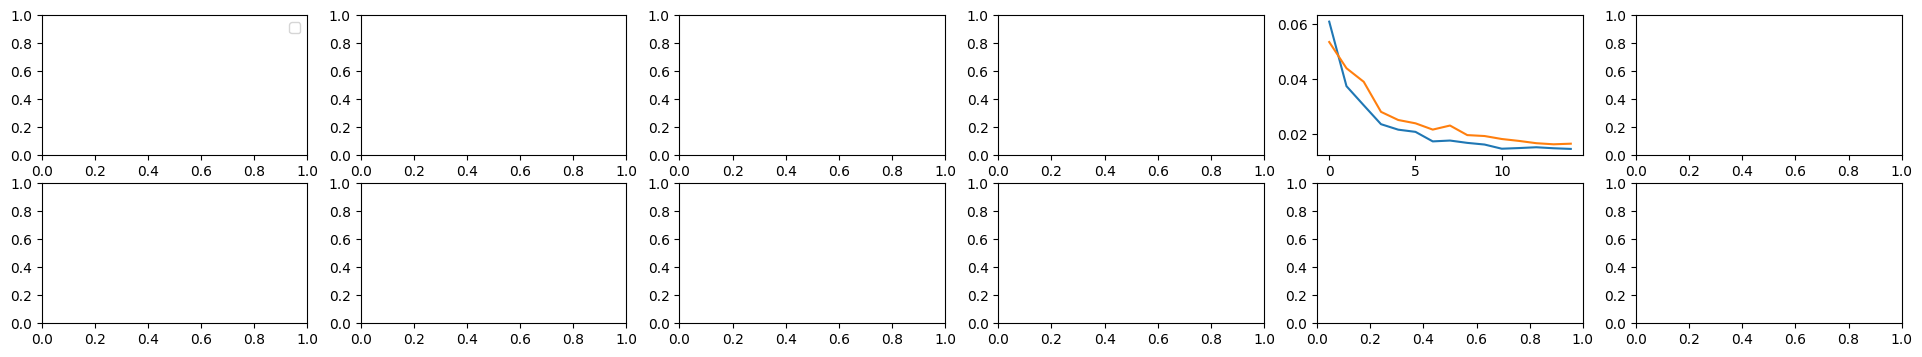

In [6]:
fig, axs = plt.subplots(2, 6, figsize=(24, 4))
for i, month in enumerate(months):
    try:
        axs.flatten()[i].plot(losses[month].train_loss, label='train')
        axs.flatten()[i].plot(losses[month].test_loss, label='test')
    except KeyError:
        pass
    
axs[0, 0].legend()

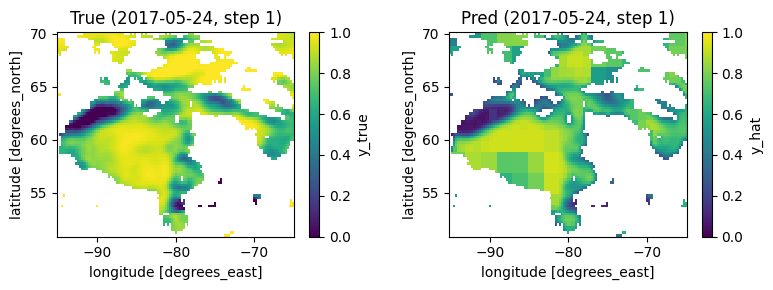

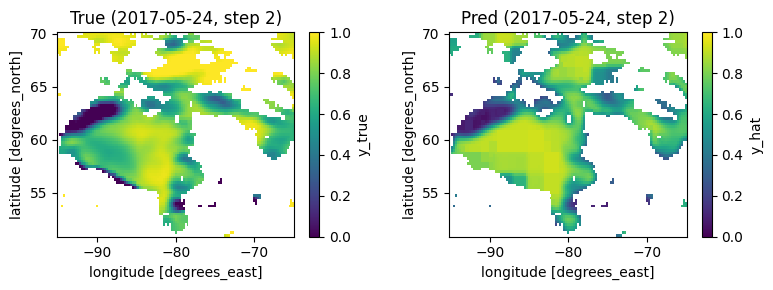

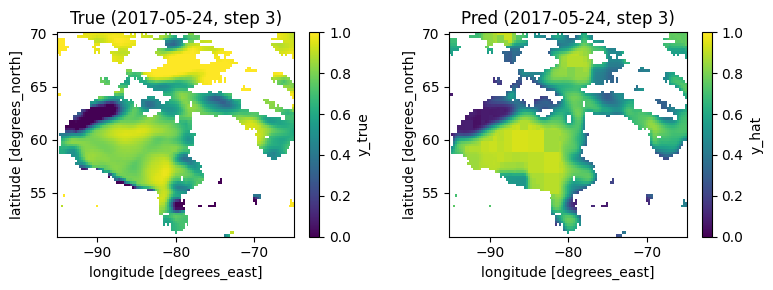

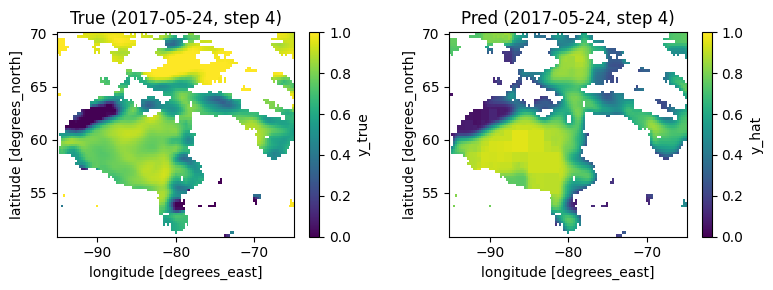

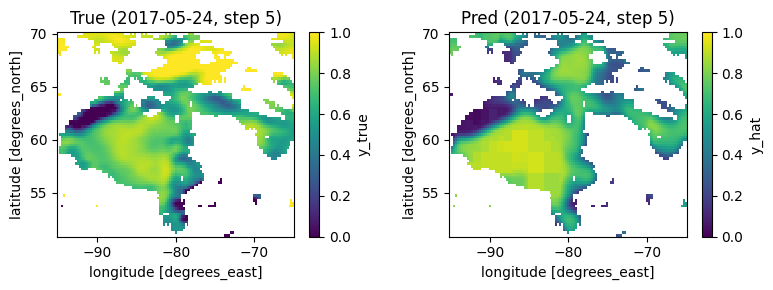

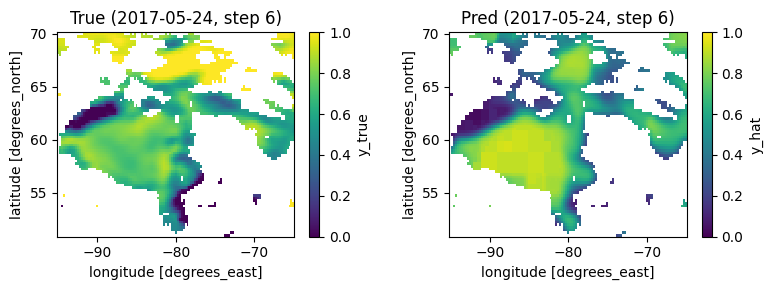

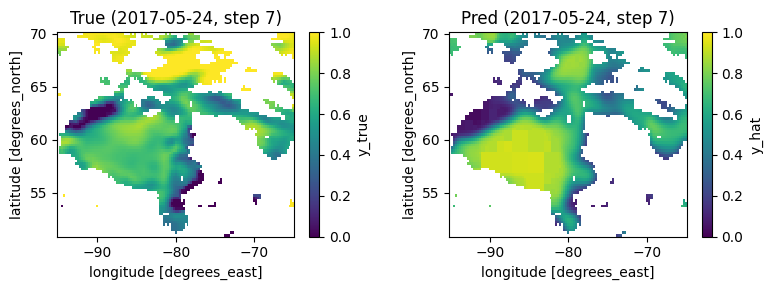

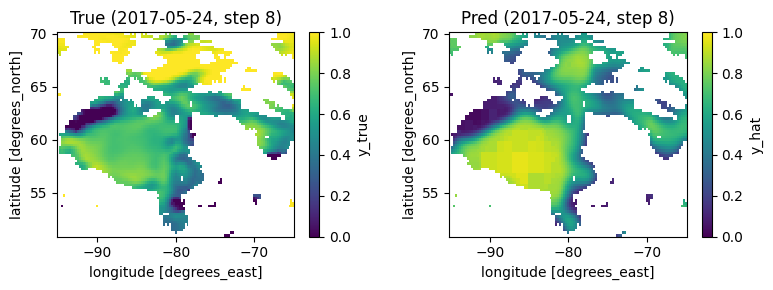

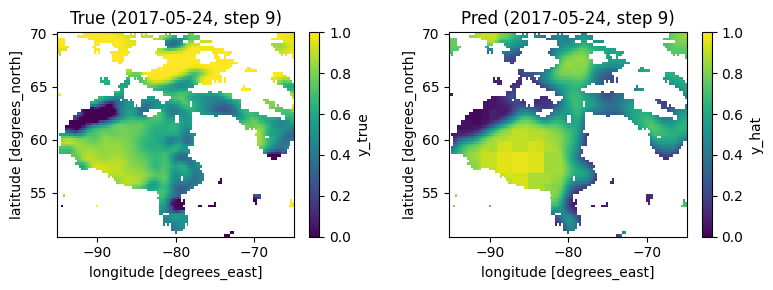

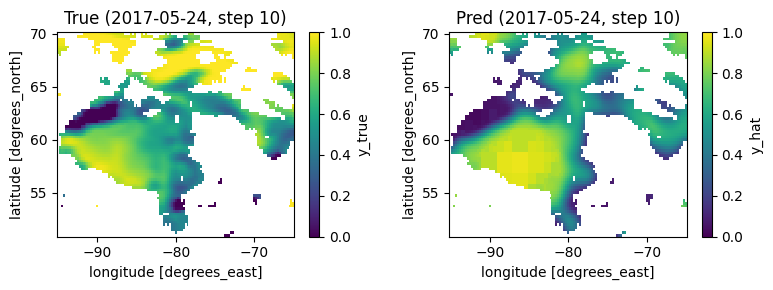

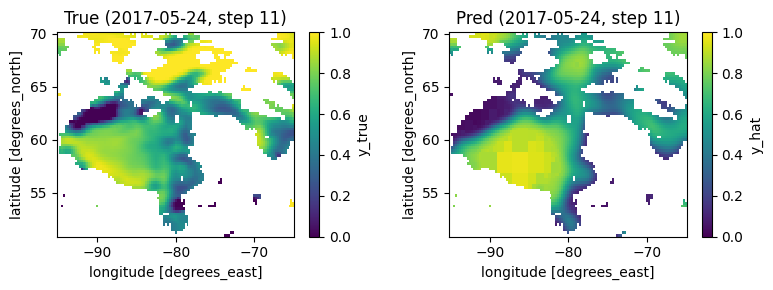

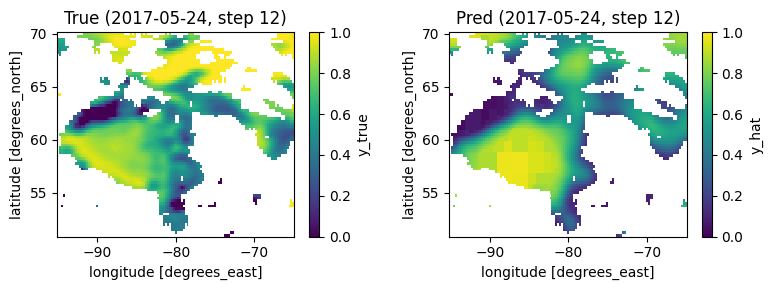

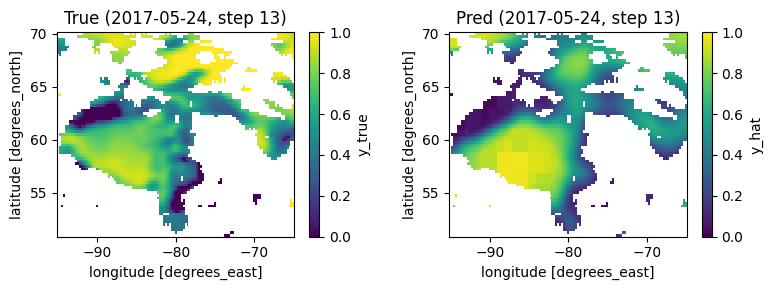

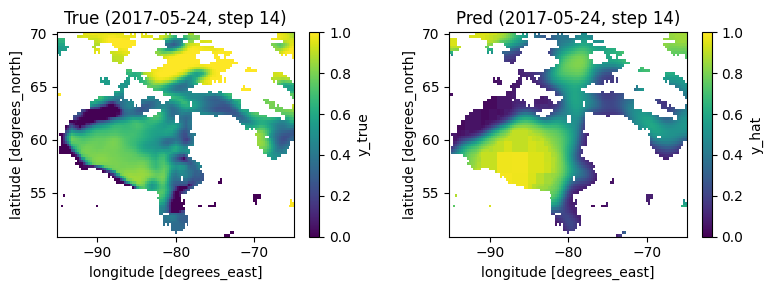

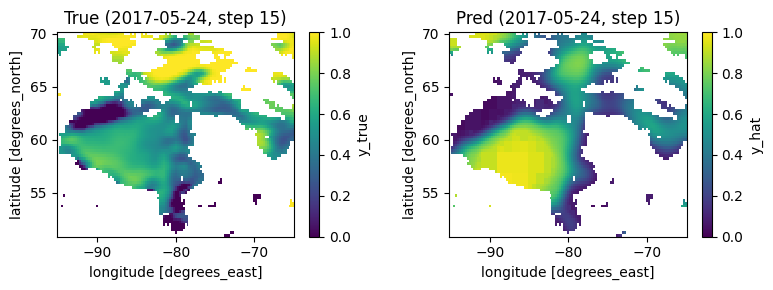

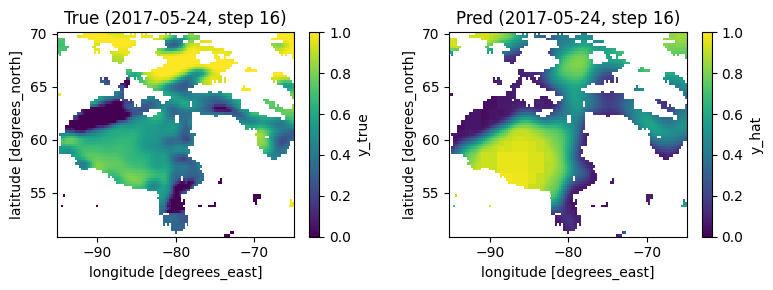

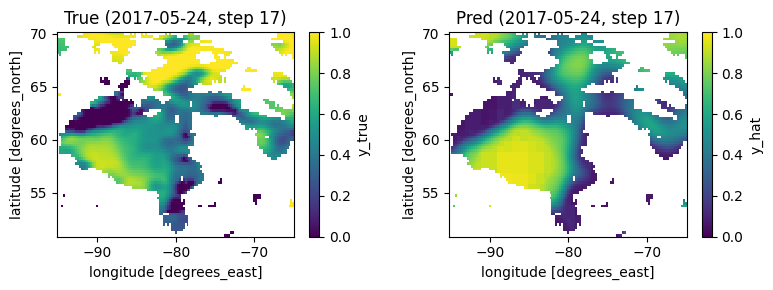

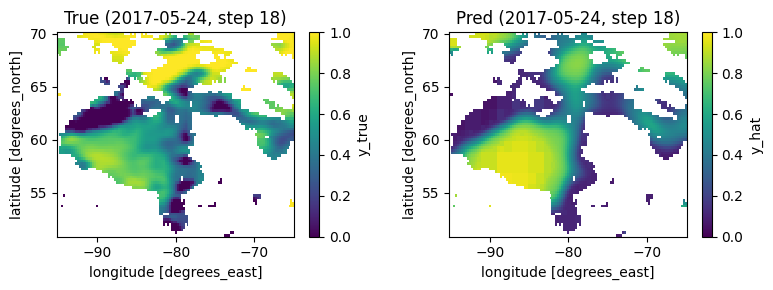

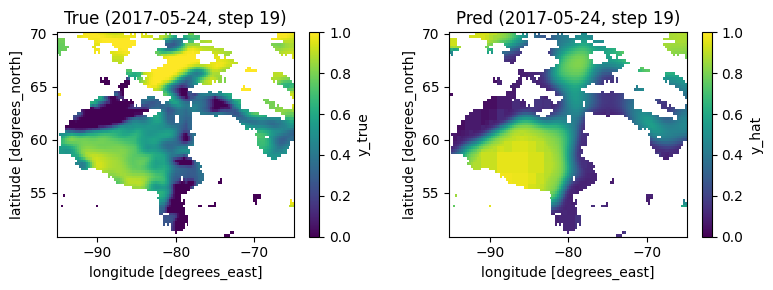

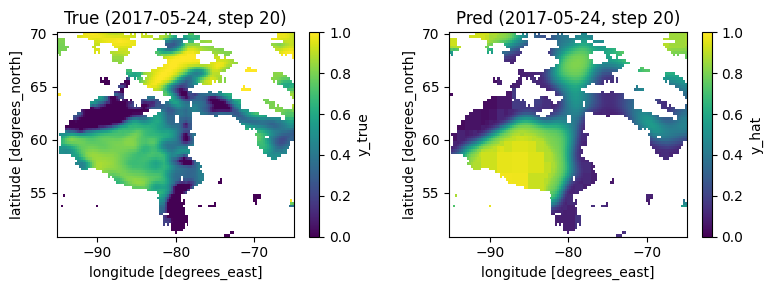

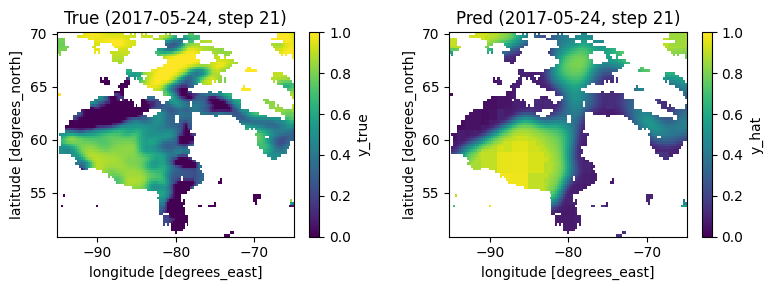

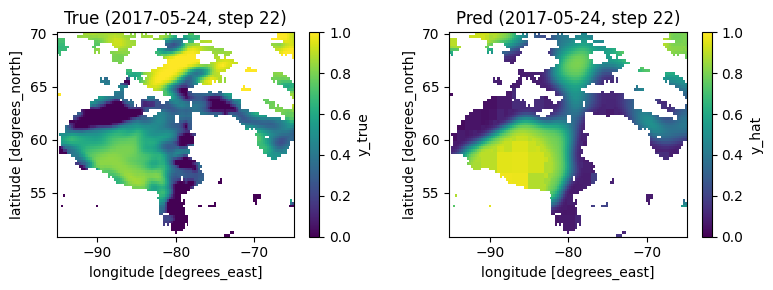

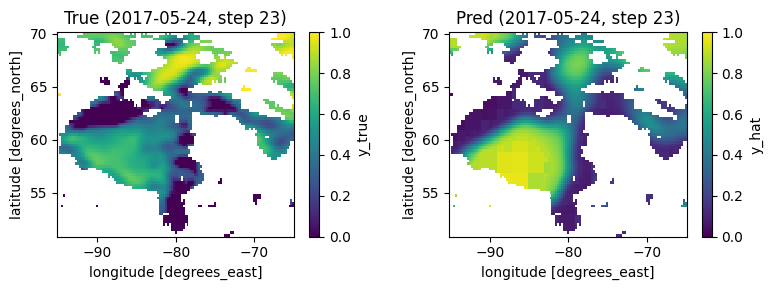

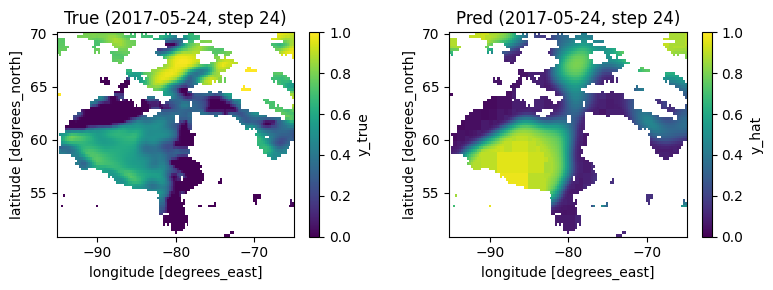

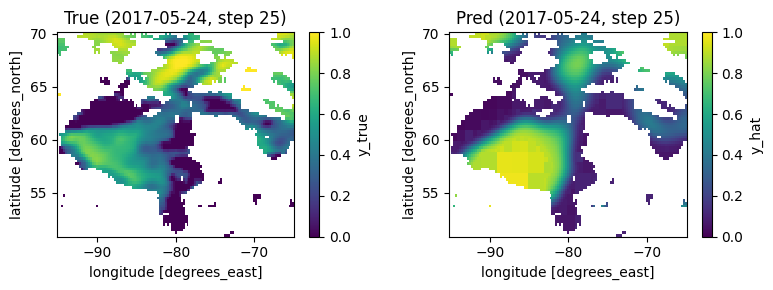

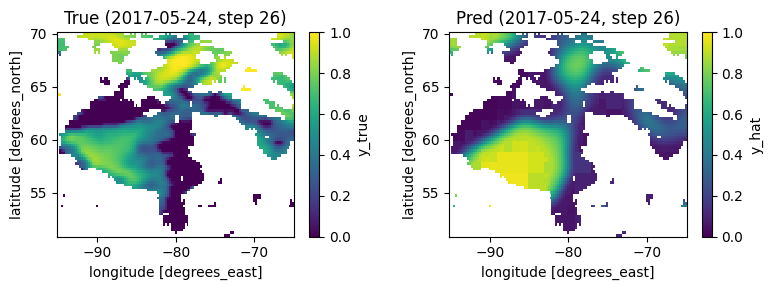

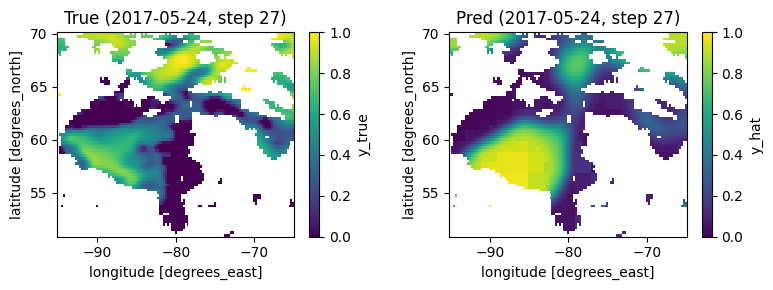

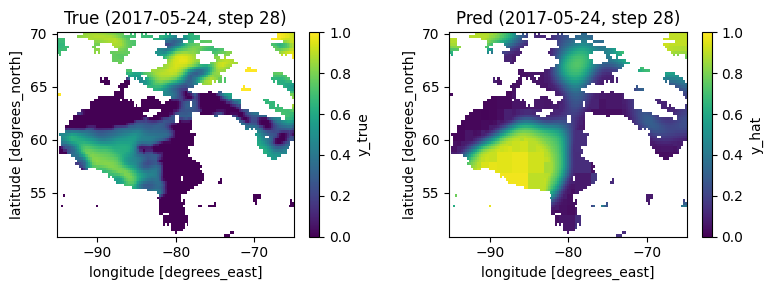

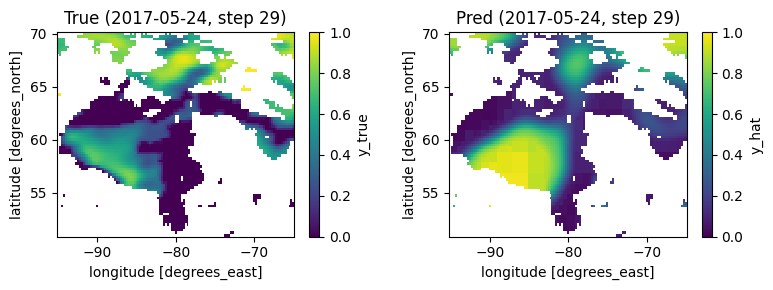

In [9]:
ld = np.random.randint(0, ds.launch_date.size)

fns = []
for ts in range(1, 30):
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    
    ds.sel(launch_date=ds.launch_date[ld], timestep=ts).where(~mask).y_true.plot(ax=axs[0], vmin=0, vmax=1)
    ds.sel(launch_date=ds.launch_date[ld], timestep=ts).where(~mask).y_hat.plot(ax=axs[1], vmin=0, vmax=1)
    axs[0].set_title(f'True ({str(ds.launch_date[ld].values)[:10]}, step {ts})')
    axs[1].set_title(f'Pred ({str(ds.launch_date[ld].values)[:10]}, step {ts})')
    plt.tight_layout()
    fn = f'ice_results_cc/gif/{str(ds.launch_date[ld].values)[:10]}_{ts}.png'
    fns.append(fn)
    plt.savefig(fn)
    plt.show()



from PIL import Image
frames = []
for fn in fns:
    new_frame = Image.open(fn)
    frames.append(new_frame)

frames[0].save(f'ice_results_cc/gif/{str(ds.launch_date[ld].values)[:10]}.gif',
               format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300,
               loop=0)

In [22]:
accuracy = False

heatmap = pd.DataFrame(0, index=range(1, 13), columns=ds.timestep)
heatmap_n = pd.DataFrame(0, index=range(1, 13), columns=ds.timestep)

for timestep in ds.timestep:
    timestep = int(timestep.values)
    for launch_date in ds.launch_date:
        arr = ds.sel(timestep=timestep, launch_date=launch_date).to_array().values
        
        if accuracy:
            arr = arr > 0.5
            err = masked_accuracy(mask)(arr[0], arr[1])
        else:
            err = masked_MSE(mask)(arr[0], arr[1])
        
        forecast_date = pd.Timestamp(launch_date.values) + relativedelta(days=timestep)
        forecast_month = forecast_date.month
        
        heatmap[timestep][forecast_month] += err
        heatmap_n[timestep][forecast_month] += 1
        
heatmap = heatmap.div(heatmap_n)

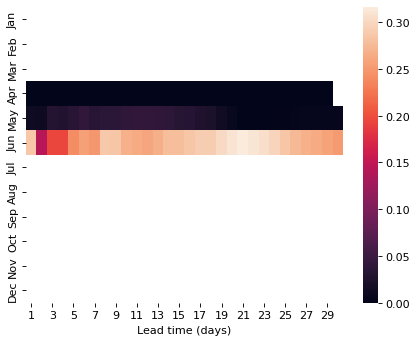

In [21]:
plt.figure(dpi=80)
sns.heatmap(heatmap, yticklabels=[month_name[i][:3] for i in range(1, 13)], vmax=None, vmin=None)
plt.xlabel('Lead time (days)')
plt.show()

In [73]:
heatmap[timestep][forecast_month] = err

In [60]:
forecast_date = pd.Timestamp(launch_date.values) + relativedelta(days=int(timestep.values))

In [64]:
forecast_date.month

3

In [29]:
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import tqdm
import seaborn as sns
import glob
from calendar import monthrange, month_name
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Masked loss / error functions 
def masked_MSE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.multiply(tf.math.squared_difference(y_pred, y_true), mask)
        return tf.reduce_mean(sq_diff)
    return loss

def masked_MAE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.multiply(tf.math.abs(tf.math.subtract(y_pred, y_true)), mask)
        return tf.reduce_mean(sq_diff)
    return loss

def masked_accuracy(mask):
    def loss(y_true, y_pred):
        y_true_masked = tf.multiply(y_true, mask)
        y_pred_masked = tf.multiply(y_pred, mask)
        return accuracy_score(y_true_masked, y_pred_masked)
    return loss

# Code for producing the accuracy heatmap
def error_heatmap(fn_format, num_ts=7, error='acc'):
    """
    fn_format: the filename format of the prediction results
        e.g. preds_{0}_direct.nc where the string formatter will insert "1" for January
    num_ts: number of timesteps predicted by the model
    error: error function to use (MAE/MSE/acc), see below
    """

    if error == 'MAE':
        error_func = masked_MAE 
    elif error == 'MSE':
        error_func = masked_MSE
    elif error == 'acc':
        error_func = masked_accuracy
    else:
        raise ValueError

    mse_df = None

    for month in range(1, 13):
        if mse_df is None:
            mse_df = pd.DataFrame(index=range(num_ts))

        try:
            ds = xr.open_dataset(fn_format.format(month))

        except FileNotFoundError:
            mse_df[month] = [np.nan] * num_ts
            continue

        mses = []
        for ts in ds.timestep:
            ds_ts = ds.sel(timestep=ts)

            mses.append(error_func(landmask)(ds_ts.ice_true, ds_ts.ice).numpy())

        mse_df[month] = mses

    return mse_df

region = 'hb'  # 'nwt'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'tensorflow'

In [24]:
ds.sel(timestep)

<xarray.Dataset>
Dimensions:    (launch_date: 31, timesteps: 30, latitude: 77, longitude: 121)
Coordinates:
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 51.0 51.25 51.5 51.75 ... 69.5 69.75 70.0
    time       (launch_date, timesteps) datetime64[ns] ...
Dimensions without coordinates: launch_date, timesteps
Data variables:
    y_hat      (launch_date, timesteps, latitude, longitude) float64 ...
    y_true     (launch_date, timesteps, latitude, longitude) float32 ...

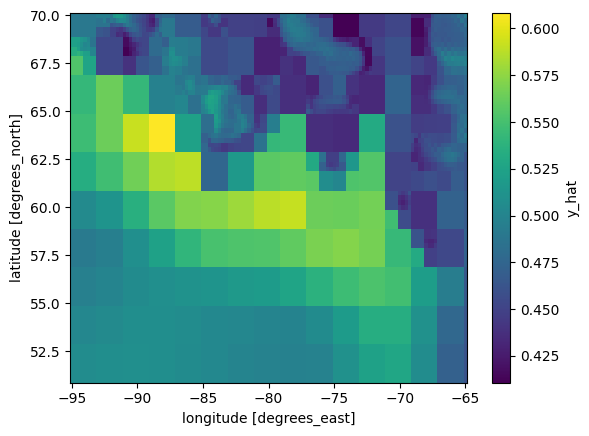

In [19]:
ds.isel(launch_date=0, timesteps=0).y_hat.plot()